In [1]:
from typing import Literal, Optional, List, Dict, Set
import re
import random
import base64
import numpy as np
import matplotlib.pyplot as plt
from html2image import Html2Image
from io import BytesIO
from matplotlib.lines import Line2D

In [2]:
NAN = 0
ONE = 1
UPTO = 2
FROM = 3
ALL = 4
BATCH_SIZE = 1
LAYER_LOW_VALUE = 0
LAYER_MAX_VALUE = 32
SAMPLING_EACH_LAYER = 10

nice_green = (0.4, 0.615, 0.647)
nice_yellow = (0.95, 0.62, 0.3)
nice_purple = (0.85, 0.5, 0.62)
        


In [2]:
import os

def list_directories(directory):
    try:
        # Get a list of all items in the directory
        items = os.listdir(directory)
        
        # Filter out only directories
        dirs = [item for item in items if os.path.isdir(os.path.join(directory, item))]
        
        return dirs
    except FileNotFoundError:
        print(f"The directory '{directory}' was not found.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{directory}'.")
        return []

def list_files(directory):
    try:
        # Get a list of all items in the directory
        items = os.listdir(directory)
        
        # Filter out only files
        files = [item for item in items if os.path.isfile(os.path.join(directory, item))]
        
        return files
    except FileNotFoundError:
        print(f"The directory '{directory}' was not found.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{directory}'.")
        return []

import json

def read_json(file_path):
    try:
        # Open the file and load the JSON data
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"The file '{file_path}' was not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON in the file '{file_path}'.")
        return None

import re

def extract_number(filename):
    # Use a regular expression to extract the number before '.json'
    match = re.match(r"(\d+)\.json", filename)
    if match:
        return int(match.group(1))  # Return the number as an integer
    else:
        print("Invalid filename format. Expected <number>.json")
        return None


In [3]:
result_dir = '../patching_results/CausalToM/Meta-Llama-3-70B-Instruct'
directories = list_directories(result_dir)
print("Directories:", directories)

experiment_results = {}
for directory in directories:
    full_dir_name = result_dir+'/'+directory
    #print(full_dir_name)
    files = list_files(full_dir_name)
    full_file_name = [full_dir_name + '/' + file for file in files]
    json_results = [{"layer": int(extract_number(files[i])), "results": read_json(file)} for i, file in enumerate(full_file_name)]
    sorted_data = sorted(json_results, key=lambda x: int(x['layer']))
    #print(sorted_data)
    experiment_results[directory] = sorted_data

Directories: ['character_position', 'object_position', 'state_position', 'pointer', 'value_fetcher', 'query_object', 'vis_2nd', 'vis_ques', 'query_character', 'source_2', 'position_transmitter', 'vis_2nd_and_ques', 'source_1', 'vis_2nd_to_1st_and_ques']


In [4]:
def plot_results(plot_data, filename="plot.pdf"):
    x_labels = plot_data["labels"]
    x_positions = np.array([int(label) for label in x_labels])
    x = np.array(x_positions, dtype=float)

    fig, ax = plt.subplots(figsize=(6, 4))

    # Accuracy: Full residual, one layer
    if "acc_full_residual_vector_one_layer" in plot_data:
        mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
        ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
        # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

    # Accuracy: Full residual, up to layer
    if "acc_full_residual_vector_upto_layer" in plot_data:
        mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
        ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
        # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

    # Accuracy: From layer
    if "acc_from_layer" in plot_data:
        mean, std, ci = plot_data["acc_from_layer"]
        ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
        # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

    # Singular vector accuracy
    if "acc_singular_vector_one_layer" in plot_data:
        mean, std, ci = plot_data["acc_singular_vector_one_layer"]
        ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank_charac']}")
        # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
        # for line in ax.get_lines():
            # line.set_alpha(0.85)

    # Format x-axis ticks
    xticks = list(range(0,80,10)) 
    # [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

    ax.set_title(plot_data["title"])
    ax.set_xlabel(plot_data["x_label"])
    ax.set_ylabel(plot_data["y_label"], color="black")
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 80)
    ax.set_xlim(x.min(), x.max())
    ax.tick_params(axis="y", labelcolor="black")
    ax.grid(False)


    # Font styling
    elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
    # if ax2:
        # elements.append(ax2.yaxis.label)
    elements += ax.get_xticklabels() + ax.get_yticklabels()
    # if ax2:
        # elements += ax2.get_yticklabels()

    for item in elements:
        item.set_fontsize(22)
        item.set_fontname("Times New Roman")

    custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'], linestyle='-', label="Full residual")
    custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'], linestyle='-', label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    
    ax.legend(
    handles=[custom_line1, custom_line2, custom_line3],
    fontsize=16,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(filename)
    plt.show()
    plt.close()


In [5]:
def compute_max_sum_mask(experiment_results, experiment_name):
    max_rank = 0
    for i in experiment_results[experiment_name]:
        metadata = i['results']['singular_vector']['metadata']['metadata']
        for j in metadata:
            mask_sum = sum(metadata[j]['mask'])  # Renamed variable
            max_rank = max(max_rank, mask_sum)
    # print("Max:", max_rank)

    return max_rank
    

# CausalToM

## State OID

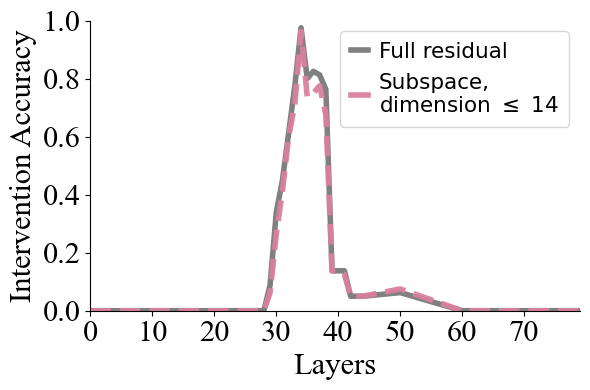

In [106]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'state_position'

file_name = "state_position"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"

# max_rank = 0
# for i in experiment_results[experiment_name]:
#     metadata = i['results']['singular_vector']['metadata']['metadata']
#     # print(metadata)
#     # for j in range(len(layers)):
#         # print(metadata[j]['0'])
#     mask_sum_1 = sum(metadata['object_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_1 = max(max_rank, mask_sum)
#     mask_sum_2 = sum(metadata['character_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_2 = max(max_rank, mask_sum)
    
# print("Max:", max_rank)


# ranks =  [obj['results']['singular_vector']['rank']
    # for obj in experiment_results[file_name]
    # if 'singular_vector' in obj.get('results', {})]
        
# max_rank = max(ranks)




# print("Maximum rank:", round(max_rank))

plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_purple,
    "rank": 14,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    # ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, custom_line2],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## Source_1

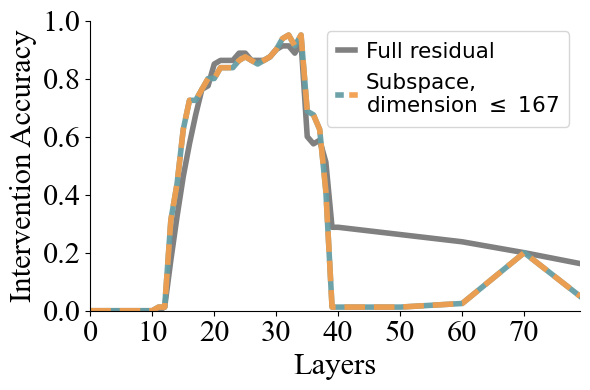

In [65]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'source_1'

file_name = "source_1"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"

# max_rank = 0
# for i in experiment_results[experiment_name]:
#     metadata = i['results']['singular_vector']['metadata']['metadata']
#     # print(metadata)
#     # for j in range(len(layers)):
#         # print(metadata[j]['0'])
#     mask_sum_1 = sum(metadata['object_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_1 = max(max_rank, mask_sum)
#     mask_sum_2 = sum(metadata['character_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_2 = max(max_rank, mask_sum)
    
# print("Max:", max_rank)


# ranks =  [obj['results']['singular_vector']['rank']
    # for obj in experiment_results[file_name]
    # if 'singular_vector' in obj.get('results', {})]
        
# max_rank = max(ranks)




# print("Maximum rank:", round(max_rank))

plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_green,
    "rank": 81+86,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])
custom_line3 = Line2D([0], [0], color=nice_yellow, alpha=0.95, linewidth=plot_data['line_width'], linestyle='-')

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, (custom_line2, custom_line3)],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## character_position

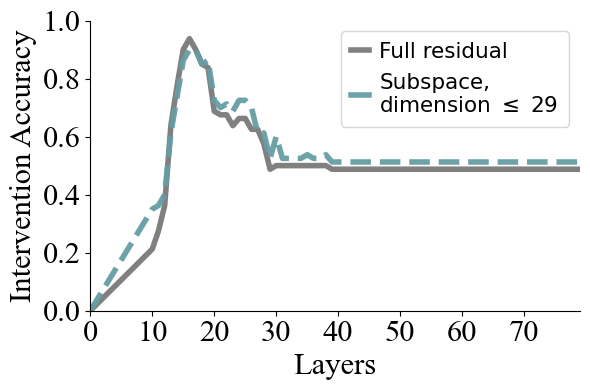

In [91]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'character_position'

file_name = "character_position"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"


# max_rank = max(
#     experiment_results[file_name][i]['results']['singular_vector']['rank']
#     for i in range(len(experiment_results[file_name]))
# )

plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_green,
    "rank": 29,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    # ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, custom_line2],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## object_position

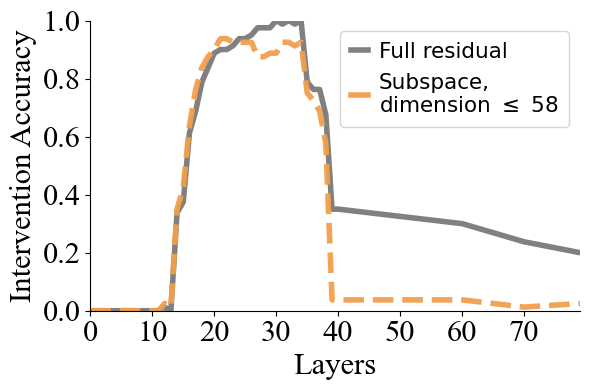

In [93]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'object_position'

file_name = "object_position"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"



plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_yellow,
    "rank": 58,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    # ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, custom_line2],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## query_character

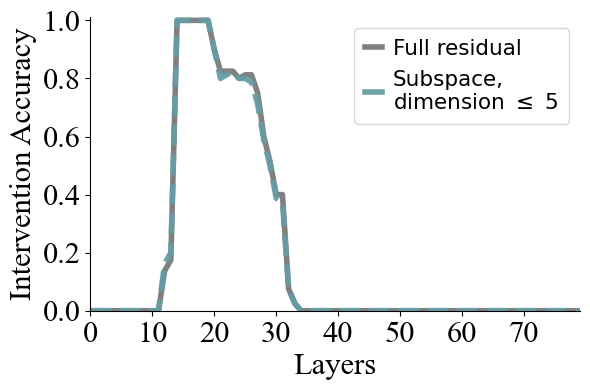

In [98]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'query_character'

file_name = "query_character"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"



plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_green,
    "rank": 5,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    # ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1.01)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, custom_line2],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## query_object

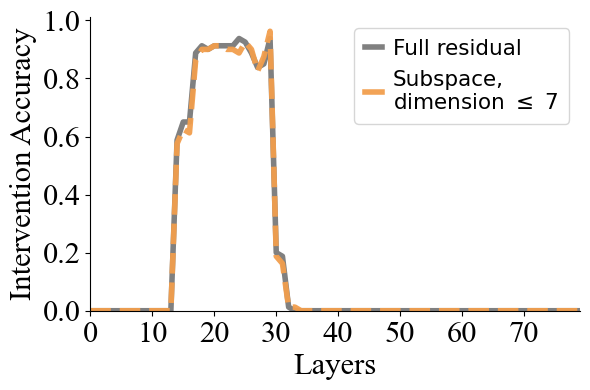

In [100]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'query_object'

file_name = "query_object"
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 
    
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]] 
raw_accuracies = []
for obj in experiment_results[file_name]:
    results = obj.get('results', {})
    if 'singular_vector' in results:
        raw_accuracies.append(results['singular_vector']['accuracy'])
    else:
        raw_accuracies.append(None)

# Now fill in missing values by averaging neighbors
accuracies_singular_vector = []
for i, val in enumerate(raw_accuracies):
    if val is not None:
        accuracies_singular_vector.append(val)
    else:
        # Average of previous and next values (if they exist and are not None)
        prev_val = raw_accuracies[i - 1] if i > 0 else None
        next_val = raw_accuracies[i + 1] if i < len(raw_accuracies) - 1 else None

        if prev_val is not None and next_val is not None:
            avg = (prev_val + next_val) / 2
        elif prev_val is not None:
            avg = prev_val
        elif next_val is not None:
            avg = next_val
        else:
            avg = 0  # or np.nan or any fallback default

        accuracies_singular_vector.append(avg)
# accuracies_principal_component = [obj['results']['principal_component']['accuracy'] for obj in experiment_results[file_name]]

layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"



plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_yellow,
    "rank": 7,
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
if "acc_full_residual_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
    ax.plot(x, mean, color="gray", linewidth=plot_data['line_width'], label="Full residual")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: Full residual, up to layer
if "acc_full_residual_vector_upto_layer" in plot_data:
    mean, std, ci = plot_data["acc_full_residual_vector_upto_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="Upto layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Accuracy: From layer
if "acc_from_layer" in plot_data:
    mean, std, ci = plot_data["acc_from_layer"]
    ax.plot(x, mean, color="black", linestyle="-", linewidth=plot_data['line_width'], label="From layer")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="black", capsize=5)

# Singular vector accuracy
if "acc_singular_vector_one_layer" in plot_data:
    mean, std, ci = plot_data["acc_singular_vector_one_layer"]
    ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")
    # ax.plot(x, mean, color=nice_yellow, linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
    # ax.errorbar(x, mean, yerr=ci, fmt="none", color="#A56CB9", capsize=4)
    # for line in ax.get_lines():
        # line.set_alpha(0.85)

# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1.01)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")

custom_line1 = Line2D([0], [0], color='gray', linewidth=plot_data['line_width'])
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'])

# Add to legend using HandlerTuple
ax.legend(
    
    [custom_line1, custom_line2],
    ["Full residual",f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    fontsize=15.5,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=0.5,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1, 1),
)


plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()


## position_transmitter + value_fetcher

[0.0, 0.0, 0.0, 0.0, 0.0125, 0.0875, 0.5375, 0.925, 0.8375, 0.8625, 0.925, 1.0, 0.9875, 0.9875, 0.975, 0.9875, 0.975, 0.975, 0.975, 0.975, 0.9625, 0.9625, 0.9875, 0.975, 0.975, 0.925, 0.725, 0.525, 0.525, 0.1125, 0.075, 0.075, 0.075, 0.05, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0125, 0.0875, 0.5375, 0.925, 0.8375, 0.8625, 0.925, 1.0, 0.9875, 0.9875, 0.975, 0.9875, 0.975, 0.975, 0.975, 0.975, 0.9625, 0.9625, 0.9875, 0.975, 0.975, 0.925, 0.725, 0.525, 0.525, 0.1125, 0.075, 0.075, 0.075, 0.05, 0.0, 0.0]
35 35


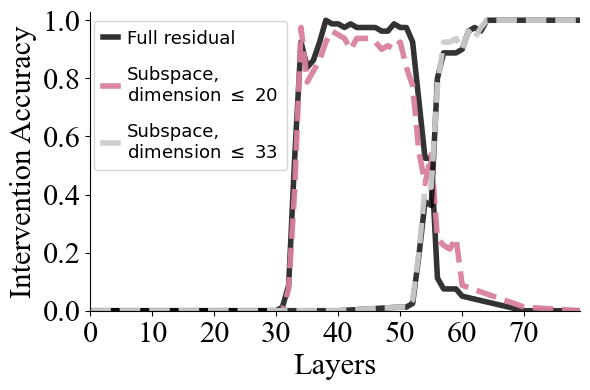

In [67]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'payloads1+2'

file_name = "position_transmitter"
file_namee = "value_fetcher"
# file_name = "source_1"

# layers = [obj['layer'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vectorr = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_namee]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 

#experiment_results['position_transmitter']
layers = [obj['layer'] for obj in experiment_results['position_transmitter']]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results['position_transmitter']]
accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results['position_transmitter']]
print(accuracies_full_residual_vector)


# layers = [obj['layer'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]]

layerss = [obj['layer'] for obj in experiment_results[file_namee]]
accuracies_full_residual_vectorr = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_namee]]
accuracies_singular_vectorr = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_namee]]


layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"

# max_rank = 0
# for i in experiment_results[experiment_name]:
#     metadata = i['results']['singular_vector']['metadata']['metadata']
#     # print(metadata)
#     # for j in range(len(layers)):
#         # print(metadata[j]['0'])
#     mask_sum_1 = sum(metadata['object_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_1 = max(max_rank, mask_sum)
#     mask_sum_2 = sum(metadata['character_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_2 = max(max_rank, mask_sum)
    
# print("Max:", max_rank)


max_rank = max(
    experiment_results[file_name][i]['results']['singular_vector']['rank']
    for i in range(len(experiment_results[file_name]))
)

max_rankk = max(
    experiment_results[file_namee][i]['results']['singular_vector']['rank']
    for i in range(len(experiment_results[file_namee]))
)


# print("Maximum rank:", round(max_rank))

plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_purple,
    "rank": int(max_rank)
}

plot_dataa = {
    "labels": layerss,
    acc_layers_full_residual_vector:[accuracies_full_residual_vectorr, 0, 0],
    acc_layers_singular_vector:[accuracies_singular_vectorr, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": 'gray',
    "rank": int(max_rankk),
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6, 4))

# Accuracy: Full residual, one layer
# if "acc_full_residual_vector_one_layer" in plot_data:
mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
print(mean)
ax.plot(x, mean, color="black", alpha=0.8, linewidth=plot_data['line_width'], label="Full residual")

mean, std, ci = plot_data["acc_singular_vector_one_layer"]
ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")

x_labels = plot_dataa["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

mean, std, ci = plot_dataa["acc_full_residual_vector_one_layer"]
print(len(mean), len(x))
ax.plot(x, mean, color="black", alpha=0.8, linewidth=plot_data['line_width'], label="Full residual")

mean, std, ci = plot_dataa["acc_singular_vector_one_layer"]
ax.plot(x, mean, color=(0.8, 0.8, 0.8), linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")



# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1.03)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")


custom_line1 = Line2D([0], [0], color='black', alpha=0.8, linewidth=plot_data['line_width'], linestyle='-', label="Full residual")
custom_line2 = Line2D([0], [0], color=plot_data['color'], alpha=0.95, linewidth=plot_data['line_width'], linestyle='-', label=f"Subspace,\n"+fr"dimension $\leq$ {plot_data['rank']}")
custom_line3 = Line2D([0], [0], color=(0.8, 0.8, 0.8), alpha=0.95, linewidth=plot_data['line_width'], linestyle='-', label=f"Subspace,\n"+fr"dimension $\leq$ {plot_dataa['rank']}")
    
ax.legend(
    handles=[custom_line1, custom_line2, custom_line3],
    fontsize=13,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=1,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(0.42, 1),
)



plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()





# plot_results(plot_data, )

## visibility

[0.025, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.175, 0.1625, 0.275, 0.7625, 0.75, 0.95, 0.95, 0.975, 0.975, 0.975, 0.9625, 0.9375, 0.8875, 0.875, 0.8375, 0.8125, 0.6875, 0.65, 0.2, 0.025, 0.025, 0.0125, 0.0125, 0.0125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.025, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.175, 0.1625, 0.275, 0.7625, 0.75, 0.95, 0.95, 0.975, 0.975, 0.975, 0.9625, 0.9375, 0.8875, 0.875, 0.8375, 0.8125, 0.6875, 0.65, 0.2, 0.025, 0.025, 0.0125, 0.0125, 0.0125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
63 63
63 63


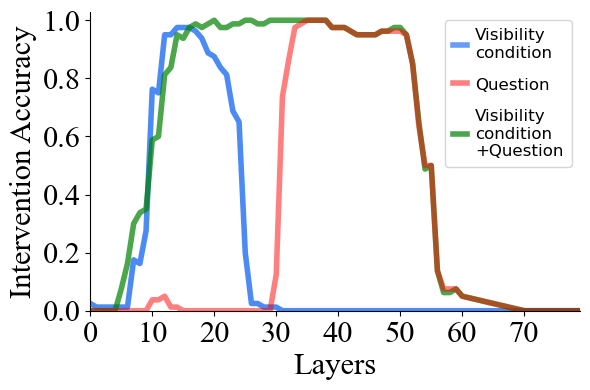

In [70]:
from matplotlib.legend_handler import HandlerTuple

experiment_name = 'visibility'

file_name = "vis_2nd"
file_namee = "vis_ques"
file_nameee = "vis_2nd_and_ques"
# file_name = "source_1"

# layers = [obj['layer'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vectorr = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_namee]]
# for i,obj in enumerate(experiment_results[file_name]):
    # print(experiment_results[file_name][0]) 

#experiment_results['position_transmitter']
layers = [obj['layer'] for obj in experiment_results[file_name]]
accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
print(accuracies_full_residual_vector)
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results['position_transmitter']]


# layers = [obj['layer'] for obj in experiment_results[file_name]]
# accuracies_full_residual_vector = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_name]]
# accuracies_singular_vector = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_name]]

layerss = [obj['layer'] for obj in experiment_results[file_namee]]
accuracies_full_residual_vectorr = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_namee]]
# accuracies_singular_vectorr = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_namee]]


layersss = [obj['layer'] for obj in experiment_results[file_nameee]]
accuracies_full_residual_vectorrr = [obj['results']['full_rank']['accuracy'] for obj in experiment_results[file_nameee]]
# accuracies_singular_vectorrr = [obj['results']['singular_vector']['accuracy'] for obj in experiment_results[file_nameee]]


layers_plot = 'ONE'

if layers_plot == 'UPTO':
    acc_layers_full_residual_vector = "acc_full_residual_vector_upto_layer"
    acc_layers_singular_vector = "acc_singular_vector_upto_layer"
    acc_layers_principal_component = "acc_principal_component_upto_layer"
elif layers_plot == 'ONE':
    acc_layers_full_residual_vector = "acc_full_residual_vector_one_layer"
    acc_layers_singular_vector = "acc_singular_vector_one_layer"
    acc_layers_principal_component = "acc_principal_component_one_layer"

# max_rank = 0
# for i in experiment_results[experiment_name]:
#     metadata = i['results']['singular_vector']['metadata']['metadata']
#     # print(metadata)
#     # for j in range(len(layers)):
#         # print(metadata[j]['0'])
#     mask_sum_1 = sum(metadata['object_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_1 = max(max_rank, mask_sum)
#     mask_sum_2 = sum(metadata['character_ordering_id']['0']['mask'])  # Renamed variable
#     max_rank_2 = max(max_rank, mask_sum)
    
# print("Max:", max_rank)


# max_rank = max(
#     experiment_results[file_name][i]['results']['singular_vector']['rank']
#     for i in range(len(experiment_results[file_name]))
# )

# max_rankk = max(
#     experiment_results[file_namee][i]['results']['singular_vector']['rank']
#     for i in range(len(experiment_results[file_namee]))
# )

# max_rankkk = max(
#     experiment_results[file_nameee][i]['results']['singular_vector']['rank']
#     for i in range(len(experiment_results[file_nameee]))
# )

# print("Maximum rank:", round(max_rank))

plot_data = {
    "labels": layers,
    acc_layers_full_residual_vector:[accuracies_full_residual_vector, 0, 0],
    # acc_layers_singular_vector:[accuracies_singular_vector, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": nice_purple,
}

plot_dataa = {
    "labels": layerss,
    acc_layers_full_residual_vector:[accuracies_full_residual_vectorr, 0, 0],
    # acc_layers_singular_vector:[accuracies_singular_vectorr, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": 'gray',
}

plot_dataaa = {
    "labels": layersss,
    acc_layers_full_residual_vector:[accuracies_full_residual_vectorrr, 0, 0],
    # acc_layers_singular_vector:[accuracies_singular_vectorrr, 0, 0],
    #acc_layers_principal_component:[accuracies_principal_component, 0, 0],
    "title": '',#file_name,
    "x_label": "Layers",
    "y_label": "Intervention Accuracy",
    "x_lower_value" : LAYER_LOW_VALUE,
    "x_higher_value" : LAYER_MAX_VALUE,
    "line_width": 4,
    "color": 'gray',
}

filename=f"../plots/patching_res_pdf/{experiment_name}.pdf"

x_labels = plot_data["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

fig, ax = plt.subplots(figsize=(6,4))

# Accuracy: Full residual, one layer
# if "acc_full_residual_vector_one_layer" in plot_data:
mean, std, ci = plot_data["acc_full_residual_vector_one_layer"]
print(mean)
ax.plot(x, mean, color=(66/255,133/255,244/255), alpha=0.95, linewidth=plot_data['line_width'], label="Full residual")

# mean, std, ci = plot_data["acc_singular_vector_one_layer"]
# ax.plot(x, mean, color=plot_data['color'], linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")

# mean, std, ci = plot_dataa["acc_singular_vector_one_layer"]
# ax.plot(x, mean, color=(0.8, 0.8, 0.8), linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")


x_labels = plot_dataaa["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

mean, std, ci = plot_dataaa["acc_full_residual_vector_one_layer"]
print(len(mean), len(x))
ax.plot(x, mean, color="green", alpha=0.7, linewidth=plot_data['line_width'], label="Full residual")

# mean, std, ci = plot_dataaa["acc_singular_vector_one_layer"]
# ax.plot(x, mean, color=(0.8, 0.8, 0.8), linestyle="--", alpha=0.95, linewidth=plot_data['line_width'], label=f"Subspace,\nmax rank = {plot_data['rank']}")

x_labels = plot_dataa["labels"]
x_positions = np.array([int(label) for label in x_labels])
x = np.array(x_positions, dtype=float)

mean, std, ci = plot_dataa["acc_full_residual_vector_one_layer"]
print(len(mean), len(x))
ax.plot(x, mean, color="red", alpha=0.5, linewidth=plot_data['line_width'], label="Full residual")



# Format x-axis ticks
xticks = list(range(0,80,10)) 
# [num for num in x_positions if num % 10 == 0 or num == x_positions[-1]]
ax.set_xticks(xticks)
ax.set_xticklabels([str(num) for num in xticks], fontsize=10, ha="center")

ax.set_title(plot_data["title"])
ax.set_xlabel(plot_data["x_label"])
ax.set_ylabel(plot_data["y_label"], color="black")
ax.set_ylim(0, 1.03)
ax.set_xlim(0, 80)
ax.set_xlim(x.min(), x.max())
ax.tick_params(axis="y", labelcolor="black")
ax.grid(False)


# Font styling
elements = [ax.title, ax.xaxis.label, ax.yaxis.label]
# if ax2:
    # elements.append(ax2.yaxis.label)
elements += ax.get_xticklabels() + ax.get_yticklabels()
# if ax2:
    # elements += ax2.get_yticklabels()

for item in elements:
    item.set_fontsize(22)
    item.set_fontname("Times New Roman")


custom_line1 = Line2D([0], [0], color=(66/255,133/255,244/255), alpha=0.8, linewidth=plot_data['line_width'], linestyle='-', label="Visibility\ncondition")
custom_line2 = Line2D([0], [0], color='red', alpha=0.5, linewidth=plot_data['line_width'], linestyle='-', label=f"Question")
custom_line3 = Line2D([0], [0], color='green', alpha=0.7, linewidth=plot_data['line_width'], linestyle='-', label=f"Visibility\ncondition\n+Question")
    
ax.legend(
    handles=[custom_line1, custom_line2, custom_line3],
    fontsize=12,
    loc="upper right",
    handlelength=0.8,     # Length of the line in the legend
    handletextpad=0.5,    # Space between line and text
    borderpad=0.5,        # Padding inside the legend box
    labelspacing=1,     # Vertical space between labels
    frameon=True,         # Keep legend frame if you want
    bbox_to_anchor=(1., 1),
)



plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(filename)
plt.show()
plt.close()





# plot_results(plot_data, )